# Detecção de Depressão utilizando dados do Twitter

Script para geração de modelos preditivos para detecção de depressão através da análise de tweets. 

Download do dataset:
https://github.com/viritaromero/Detecting-Depression-in-Tweets/blob/master/sentiment_tweets3.csv

Atributos:
- message: Texto do Tweet
- label: Indicação de depressão (0 - Não, 1 - Sim)

 ### Importar pacotes para pré-processamento e análise de dados

In [1]:
import pandas as pd
import numpy as np
import re
import string
from wordsegment import load, segment
from textblob import Word
import inflect
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Wesllei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Ler os dados

In [2]:
dados = pd.read_csv('sentiment_tweets3.csv', encoding = 'ISO-8859-1', sep = ',')

In [3]:
# del dados['Unnamed: 0']

In [4]:
# dados = dados[0:20]

In [5]:
dados.head()

,Unnamed: 0,message,label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [6]:
dados.describe()

,Unnamed: 0,label
count,10314.000000,10314.000000
mean,491253.470525,0.224355
std,261688.134407,0.417177
min,106.000000,0.000000
25%,263019.250000,0.000000
50%,514988.000000,0.000000
75%,773521.500000,0.000000
max,802313.000000,1.000000


In [7]:
dados.shape

(10314, 3)

### Criar novos atributos
- Número de palavras
- Tem hashtag?
- Tem menção?
- Tem link?

In [8]:
def contaPalavras(x):
    palavras = x.split()
    return len(palavras)

In [9]:
dados['num_palavras'] = dados['message'].apply(contaPalavras)

In [10]:
def verificaHashtag(x):
    if(re.findall(r'\B#\w*[a-zA-Z]+\w*', x) != []):
        return True
    return False

In [11]:
dados['hashtag'] = dados['message'].apply(verificaHashtag)

In [12]:
def verificaMencao(x):
    if(re.findall(r'\B@\w*[a-zA-Z]+\w*', x) != []):
        return True
    return False

In [13]:
dados['mencao'] = dados['message'].apply(verificaMencao)

In [14]:
def verificaLink(x):
    if(re.findall(r'https?:\/\/(www\.)?[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', x) != []):
        return True
    return False

In [15]:
dados['link'] = dados['message'].apply(verificaLink)

In [16]:
dados.head()

,Unnamed: 0,message,label,num_palavras,hashtag,mencao,link
0,106,just had a real good moment. i missssssssss hi...,0,11,False,False,False
1,217,is reading manga http://plurk.com/p/mzp1e,0,4,False,False,True
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0,4,False,True,True
3,288,@lapcat Need to send 'em to my accountant tomo...,0,22,False,True,False
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,5,False,False,False


### Pré-processamento
- Remover aspas duplas
- Remover menções e links
- Remover caracteres especiais e números
- Corrigir gramática (Ex: "girlllll" => "girl")
- Remover pontuações
- Transformar em lower case
- Transformar números em palavras (Não aplicado)
- Dividir palavras (Ex: "#followfriday" => "follow friday" => depois de remover a hashtag também)
- Lemmatize verbs

In [17]:
# Remover '&quot'

def removeAspasDuplas(x):
    texto = str(x)
    texto = texto.replace('&quot','')
        
    return texto

In [18]:
dados['message'] = dados['message'].apply(removeAspasDuplas)

In [19]:
# dados.head(20)

In [20]:
# Remover menções e links

def removeMencao(x):
    return ''.join(re.sub(r'\B@\w*[a-zA-Z]+\w*', '', x))

def removeLink(x):
    return ''.join(re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', 
                           '', x))

In [21]:
dados['message'] = dados['message'].apply(removeMencao)
dados['message'] = dados['message'].apply(removeLink)

In [22]:
# dados.head(20)

In [23]:
# Remover caracteres especiais e números

def removeCaraceresEspeciaisNumeros(x):
    return ' '.join(re.sub('[^A-Za-z]+', ' ', x).split())

In [24]:
dados['message'] = dados['message'].apply(removeCaraceresEspeciaisNumeros)

In [25]:
# dados.head(20)

In [26]:
# Corrigir gramática

# Reduz a quantidade de caracteres repetidos para, no máximo, 2 (Ex: 'missssssssss' => 'miss')
def reduzTamanho(x):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", x)

# Corrige a gramática das palavras (Ex: 'jus' => 'just')
def corrigeGramatica(x):
    palavras = x.split()
        
    for i in range(0,len(palavras)):
        p = Word(palavras[i])
        palavras[i] = p.spellcheck()[0][0]
    
    return ' '.join(palavras)

In [27]:
dados['message'] = dados['message'].apply(reduzTamanho)
dados['message'] = dados['message'].apply(corrigeGramatica)

In [28]:
# dados.head(20)

In [29]:
# Remover pontuações

def removePontuacao(x):   
    texto = str(x)
    
    for punc in string.punctuation:
        texto = texto.replace(punc,'')
        
    return texto

In [30]:
dados['message'] = dados['message'].apply(removePontuacao)

In [31]:
# dados.head(20)

In [32]:
# Transformar em lower case

dados['message'] = dados['message'].str.lower()

In [33]:
# dados.head(20)

In [34]:
# Transformar números em palavras

p = inflect.engine()

def transformaNumeros(x):
    palavras = x.split()
    
    for i in range(0,len(palavras)):
        if(palavras[i].isdigit()):
            palavras[i] = p.number_to_words(palavras[i])
            
    return ' '.join(palavras)

In [35]:
# dados['message'] = dados['message'].apply(transformaNumeros)

In [36]:
# dados.head(20)

In [37]:
# Dividir palavras 

load()

def dividePalavras(x):
    return ' '.join(segment(x))

In [38]:
dados['message'] = dados['message'].apply(dividePalavras)

In [39]:
# dados.head(20)

In [40]:
# Lemmatize verbs

lemmatizer = WordNetLemmatizer()

def lemmatize(x):
    palavras = x.split()
    
    for i in range(0,len(palavras)):
        palavras[i] = lemmatizer.lemmatize(palavras[i], pos='v')
        
    return ' '.join(palavras)

In [41]:
dados['message'] = dados['message'].apply(lemmatize)

In [42]:
# dados.head(20)

### Criar novo atributo
- Tem o termo 'depression'?

In [43]:
def verificaTermoDepressao(x):
    return 'depression' in (x)

In [44]:
dados['termo_depressao'] = dados['message'].apply(verificaTermoDepressao)

In [45]:
# dados[dados['termo_depressao'] == True]

### Pré-processamento
- Remover stop words

In [46]:
stops = stopwords.words('english')

dados['message'] = dados['message'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stops)]))

In [47]:
# dados.head(20)

### Salvar dados pré-processados

In [48]:
dados.to_csv('sentiment_tweets3_processed.csv', encoding='ISO-8859-1', sep=',')

### Ler dados processados

In [2]:
df = pd.read_csv('sentiment_tweets3_processed.csv', encoding = 'ISO-8859-1', sep = ',')

In [3]:
# del df['Unnamed: 0']

In [4]:
df.head()

,Unnamed: 0,Unnamed: 0.1,message,label,num_palavras,hashtag,mencao,link,termo_depressao
0,0,106,real good moment miss much,0,11,False,False,False,False
1,1,217,read mania e,0,4,False,False,True,False
2,2,220,yll,0,4,False,True,True,False
3,3,288,need send em accountant tomorrow oddly wasnt e...,0,22,False,True,False,False
4,4,540,add myspace space com look thunder,0,5,False,False,False,False


In [5]:
df.shape

(10314, 9)

### Visualizações sobre os dados

In [6]:
palavras = []

def montaLista(x):
    palavra = str(x).split()
    
    for p in palavra:
        palavras.append(p)

In [7]:
df['message'].apply(montaLista)

0        None
1        None
2        None
3        None
4        None
         ... 
10309    None
10310    None
10311    None
10312    None
10313    None
Name: message, Length: 10314, dtype: object

In [8]:
# pd.DataFrame(palavras).tail(10)

In [9]:
frequencia = nltk.FreqDist(palavras)
maisComuns = frequencia.most_common(100)

In [10]:
maisComuns = pd.DataFrame(maisComuns)
maisComuns.head()

,0,1
0,depression,2495
1,get,974
2,go,906
3,im,749
4,good,726


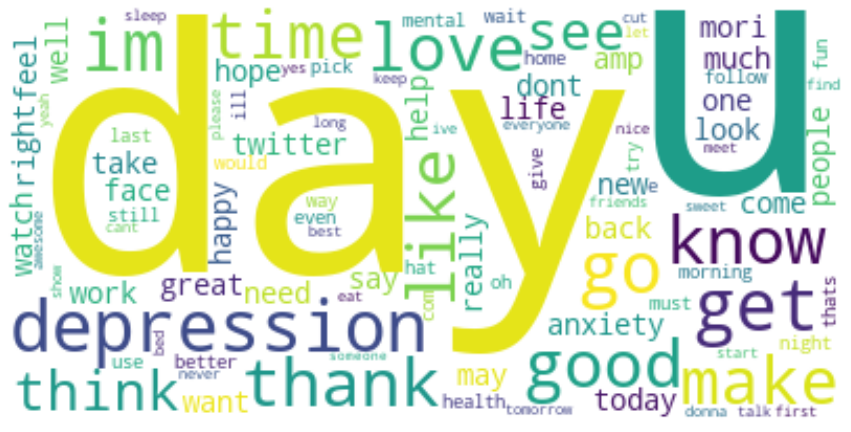

In [11]:
stops = stopwords.words('english')

nuvem = WordCloud(background_color = 'white',
                  #max_font_size = 50,
                  stopwords = stops,
                  max_words = 100)
nuvem.generate(' '.join(maisComuns[0]))
plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(nuvem, interpolation='bilinear')

In [12]:
dados = df.reset_index()

In [82]:
depressao = dados[['index','label']].groupby(['label']).count().reset_index()

labels = depressao['label'].unique()

fig = go.Figure(data=[
    go.Bar(name='Com Hashtag', x=labels, y=depressao['index'])
])

fig.update_layout(
    title='Posts depressivos e não depressivos',
    yaxis_title='Quantidade',
    xaxis = dict(
        tickvals = ['0','1'],
        ticktext = ['Não Depressivo','Depressivo']),
    width = 900,
    height = 700
)

fig.show()

In [14]:
hashtag = dados[['index','label','hashtag']].groupby(['label','hashtag']).count().reset_index()

labels = hashtag['label'].unique()

fig = go.Figure(data=[
    go.Bar(name='Com Hashtag', x=labels, y=hashtag[hashtag['hashtag']==True]['index'],
           text=hashtag[hashtag['hashtag']==True]['index'], textposition='outside'),
    go.Bar(name='Sem Hashtag', x=labels, y=hashtag[hashtag['hashtag']==False]['index'],
           text=hashtag[hashtag['hashtag']==False]['index'], textposition='outside')
])

fig.update_layout(
    title='Quantidade de posts depressivos com e sem hashtag',
    yaxis_title='Quantidade',
    xaxis = dict(
        tickvals = ['0','1'],
        ticktext = ['Não Depressivo','Depressivo']),
    width = 900,
    height = 700
)

fig.show()

In [15]:
mencao = dados[['index','label','mencao']].groupby(['label','mencao']).count().reset_index()

labels = mencao['label'].unique()

fig = go.Figure(data=[
    go.Bar(name='Com Menção', x=labels, y=mencao[mencao['mencao']==True]['index'],
           text=mencao[mencao['mencao']==True]['index'], textposition='outside'),
    go.Bar(name='Sem Menção', x=labels, y=mencao[mencao['mencao']==False]['index'],
           text=mencao[mencao['mencao']==False]['index'], textposition='outside')
])

fig.update_layout(
    title='Quantidade de posts depressivos com e sem menções',
    yaxis_title='Quantidade',
    xaxis = dict(
        tickvals = ['0','1'],
        ticktext = ['Não Depressivo','Depressivo']),
    width = 900,
    height = 700
)

fig.show()

In [16]:
link = dados[['index','label','link']].groupby(['label','link']).count().reset_index()

labels = link['label'].unique()

fig = go.Figure(data=[
    go.Bar(name='Com Link', x=labels, y=link[link['link']==True]['index'],
           text=link[link['link']==True]['index'], textposition='outside'),
    go.Bar(name='Sem Link', x=labels, y=link[link['link']==False]['index'],
           text=link[link['link']==False]['index'], textposition='outside')
])

fig.update_layout(
    title='Quantidade de posts depressivos com e sem links',
    yaxis_title='Quantidade',
    xaxis = dict(
        tickvals = ['0','1'],
        ticktext = ['Não Depressivo','Depressivo']),
    width = 900,
    height = 700
)

fig.show()

In [17]:
termo_depressao = dados[['index','label','termo_depressao']].groupby(['label','termo_depressao']).count().unstack(fill_value=0).stack().reset_index()
termo_depressao

,label,termo_depressao,index
0,0,False,8000
1,0,True,0
2,1,False,10
3,1,True,2304


In [83]:
termo_depressao = dados[['index','label','termo_depressao']].groupby(['label','termo_depressao']).count().unstack(fill_value=0).stack().reset_index()

labels = link['label'].unique()

fig = go.Figure(data=[
    go.Bar(name='Com o termo "depressão"', x=labels, y=termo_depressao[termo_depressao['termo_depressao']==True]['index'],
           text=termo_depressao[termo_depressao['termo_depressao']==True]['index'], textposition='outside'),
    go.Bar(name='Sem o termo "depressão"', x=labels, y=termo_depressao[termo_depressao['termo_depressao']==False]['index'],
           text=termo_depressao[termo_depressao['termo_depressao']==False]['index'], textposition='outside')
])

fig.update_layout(
    title='Distribuição de posts com o termo "depressão"',
    yaxis_title='Quantidade',
    xaxis = dict(
        tickvals = ['0','1'],
        ticktext = ['Não Depressivo','Depressivo']),
    width = 900,
    height = 700
)

fig.show()

In [101]:
fig = go.Figure()

fig.add_trace(go.Box(
    y=dados[dados['label']==0]['num_palavras'],
    name='Não Depressivo',
    marker_color='royalblue',
    boxmean='sd' # represent mean and standard deviation
))

fig.add_trace(go.Box(
    y=dados[dados['label']==1]['num_palavras'],
    name='Depressivo',
    marker_color='darkblue',
    boxmean='sd' # represent mean and standard deviation
))

fig.update_layout(
    title='Distribuição do número de palavras',
    yaxis_title='Número de palavras',
    width = 900,
    height = 700
)

fig.show()

### Importar pacotes para criação dos modelos

In [20]:
import time
import gensim
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dropout, Dense, LSTM, Bidirectional, Embedding, Flatten
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### Dividir os dados em subconjuntos de treinamento e teste de forma balanceada

In [21]:
df.shape

(10314, 9)

In [22]:
df.dropna().shape

(10257, 9)

In [23]:
df.dropna(inplace=True)
df['message'] = df['message'].map(str)

In [24]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'message', 'label', 'num_palavras',
       'hashtag', 'mencao', 'link', 'termo_depressao'],
      dtype='object')

In [25]:
X = df[['message','hashtag','mencao','link','num_palavras','termo_depressao']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,stratify = y)

In [26]:
y.value_counts()

0    7949
1    2308
Name: label, dtype: int64

In [27]:
y_train.value_counts()

0    5564
1    1615
Name: label, dtype: int64

In [28]:
y_test.value_counts()

0    2385
1     693
Name: label, dtype: int64

In [29]:
# O modelo BiLSTM só analisa os dados do texto do tweet para detectar depressão

X_train_bilstm = X_train['message']
X_test_bilstm = X_test['message']

In [30]:
# O modelo Random Forest analisa todos os dados do tweet para detectar depressão, com exceção do texto do tweet

X_train_rf = X_train[['hashtag','mencao','link','num_palavras','termo_depressao']]
X_test_rf = X_test[['hashtag','mencao','link','num_palavras','termo_depressao']]

### Criar Word Embeddings com Word2Vec

In [31]:
MAX_SEQUENCE_LENGTH = 100

In [32]:
sentences = df['message'].map(str).map(lambda x: x.split()).to_list()

modelWord2Vec = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=8, iter=10)
word2VecWeights = modelWord2Vec.wv.vectors
vocabSize, embeddingSize = word2VecWeights.shape

In [33]:
def word2token(word):
    try:
        return modelWord2Vec.wv.vocab[word].index
    except KeyError:
        return 0

In [34]:
len(X_train_bilstm)

7179

In [35]:
len(X_test_bilstm)

3078

In [36]:
# Concatenar X e y para treino e teste
# Necessário para adaptar os dados para o treinamento e teste do modelo BiLSTM

dfTrainBiLSTM = pd.concat([X_train_bilstm, y_train], axis=1, sort=False)
dfTestBiLSTM = pd.concat([X_test_bilstm, y_test], axis=1, sort=False)

In [37]:
dfTrainBiLSTM.shape

(7179, 2)

In [38]:
dfTestBiLSTM.shape

(3078, 2)

In [39]:
class SequenceIterator:
    def __init__(self, dados):
        self.dados = dados
        self.label, self.ccount = np.unique(dados['label'], return_counts=True)
        self.seq_length = len(sentences)
        
    def __iter__(self):
        
        # Mapeamento Word2Token
        for tweets, label in zip(self.dados.iloc[:, 0], self.dados.iloc[:, 1]):
            words = np.array([word2token(w) for w in tweets.split(' ')[:self.seq_length] if w != ''])
            
            # Retorna generator
            yield (words, label)

In [40]:
# Gerar as sequences

sequencesTrain = SequenceIterator(dfTrainBiLSTM)
sequencesTest = SequenceIterator(dfTestBiLSTM)

In [41]:
# Retorna iterator

catDictTrain = {k: v for k, v in zip(sequencesTrain.label, range(len(sequencesTrain.label)))}
catDictTest = {k: v for k, v in zip(sequencesTest.label, range(len(sequencesTest.label)))}

In [42]:
# Obter os conjuntos X e y 

xTrain = []
yTrain = []
for w, c in sequencesTrain:
    xTrain.append(w)
    yTrain.append(catDictTrain[c])
    
xTest = []
yTest = []
for w, c in sequencesTest:
    xTest.append(w)
    yTest.append(catDictTest[c])

In [43]:
# Preencher sequences com 0

X_train_bilstm = pad_sequences(xTrain, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
y_train_bilstm = np.array(yTrain)

X_test_bilstm = pad_sequences(xTest, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
y_test_bilstm = np.array(yTest)

### Criar modelo Bi-LSTM

O modelo possui a seguinte estrutura de camadas:
- Word Embedding (Word2Vec)
- Bi-LSTM
- Dropout
- Bi-LSTM
- Dropout
- Totalmente conectada
- Softmax

In [44]:
registros = X_train_bilstm.shape[0]
atributos = X_train_bilstm.shape[1]

In [45]:
registros

7179

In [46]:
# Inicializar modelo sequencial
modelBiLSTM = Sequential()

# Adicionar camada de word embeddings
modelBiLSTM.add(Embedding(input_dim=vocabSize,
                          output_dim=embeddingSize,
                          weights=[word2VecWeights],
                          input_length=MAX_SEQUENCE_LENGTH,
                          mask_zero=True,
                          trainable=False))

# Adicionar primeira camada Bi-LSTM
modelBiLSTM.add(Bidirectional(LSTM(units=128, batch_input_shape=(8,registros,atributos),
                                   return_sequences=True, recurrent_dropout=0.2)))

# Adicionar uma camada dropout
modelBiLSTM.add(Dropout(rate=0.5))

# Adicionar segunda camada Bi-LSTM
modelBiLSTM.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.2)))

# Adicionar uma camada dropout
modelBiLSTM.add(Dropout(rate=0.5))

# Adicionar uma camada totalmente conectada com 128 neurônios e função de ativação relu
modelBiLSTM.add(Flatten())
modelBiLSTM.add(Dense(units=128, activation='relu'))

# Adicionar camada softmax
modelBiLSTM.add(Flatten())
modelBiLSTM.add(Dense(units=2, activation='softmax'))

# Imprimir o modelo
modelBiLSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          229200    
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 256)          234496    
_________________________________________________________________
dropout (Dropout)            (None, 100, 256)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 256)          394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

In [47]:
# Otimizador
opt = Adam(lr = 0.001)

# Compilar o modelo
modelBiLSTM.compile(loss='binary_crossentropy',
                    optimizer=opt,
                    metrics=['accuracy'])

In [48]:
# Treinar modelo Bi-LSTM

tempoInicio = time.time()

bilstm = modelBiLSTM.fit(X_train_bilstm, y_train_bilstm,
                         validation_data=(X_test_bilstm,y_test_bilstm),
                         epochs=3,
                         batch_size=8,
                         verbose=1)

tempoSeg = time.time() - tempoInicio
tempoMin = tempoSeg / 60
tempoHor = tempoMin / 60
print('Tempo (segundos): ' + str(tempoSeg))
print('Tempo (minutos): ' + str(tempoMin))
print('Tempo (horas): ' + str(tempoHor))

Epoch 1/3
898/898 [==============================] - 897s 999ms/step - loss: 0.6932 - accuracy: 0.4970 - val_loss: 0.6931 - val_accuracy: 0.2245
Epoch 2/3
898/898 [==============================] - 863s 961ms/step - loss: 0.6932 - accuracy: 0.4906 - val_loss: 0.6931 - val_accuracy: 0.7758
Epoch 3/3
898/898 [==============================] - 884s 984ms/step - loss: 0.6932 - accuracy: 0.5168 - val_loss: 0.6931 - val_accuracy: 0.7749
Tempo (segundos): 2668.4627850055695
Tempo (minutos): 44.47437975009282
Tempo (horas): 0.741239662501547


In [96]:
predicted = modelBiLSTM.predict_classes(X_test_bilstm)
print(classification_report(y_test_bilstm, predicted))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      2385
           1       0.00      0.00      0.00       693

    accuracy                           0.77      3078
   macro avg       0.39      0.50      0.44      3078
weighted avg       0.60      0.77      0.68      3078



c:\users\wesllei\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [97]:
print(confusion_matrix(y_test_bilstm, predicted))

[[2385    0]
 [ 693    0]]


[Text(0, 0.5, 'Não Depressivo'), Text(0, 1.5, 'Depressivo')]

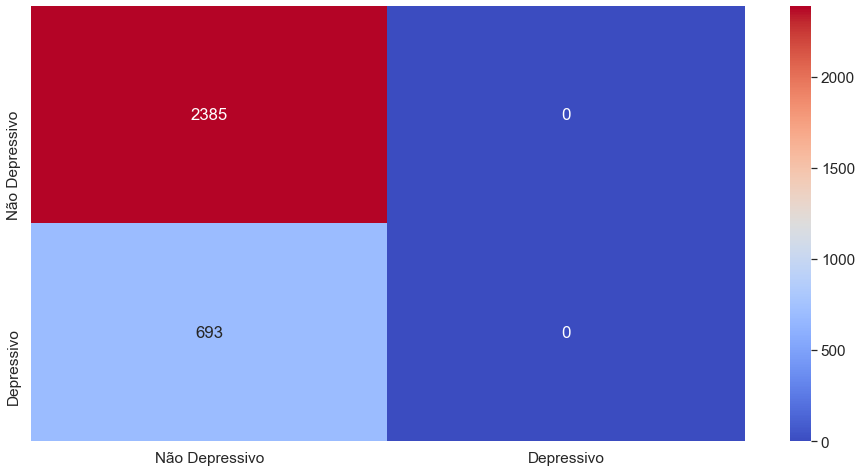

In [98]:
cm = confusion_matrix(y_test_bilstm, predicted)

sns.set(font_scale=1.4)

fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(cm, cmap='coolwarm', annot=True, fmt='g', ax=ax)
ax.set_xticklabels(['Não Depressivo','Depressivo'])
ax.set_yticklabels(['Não Depressivo','Depressivo'])

#### Training and Validation Accuracy

In [52]:
def plot_graphs(model, string):
  plt.figure(figsize=(16,8))
  plt.plot(model.history[string])
  plt.plot(model.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

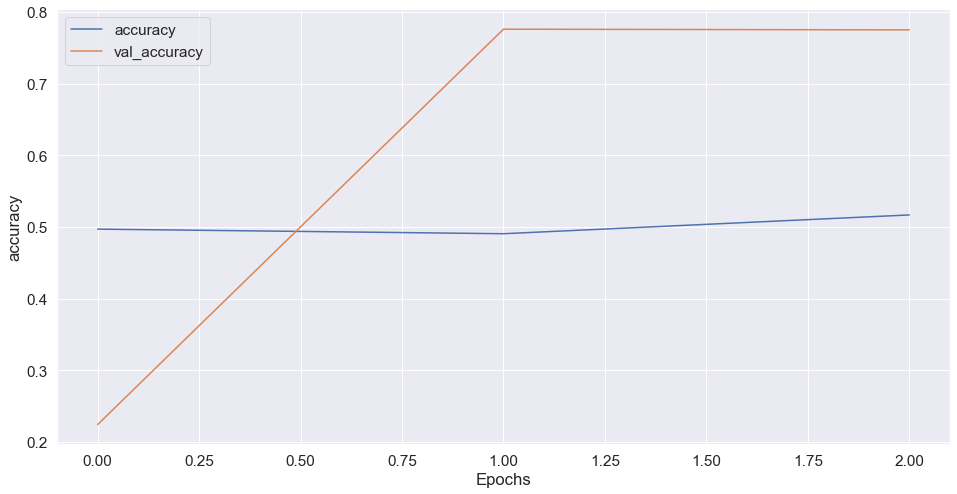

In [53]:
plot_graphs(bilstm, 'accuracy')

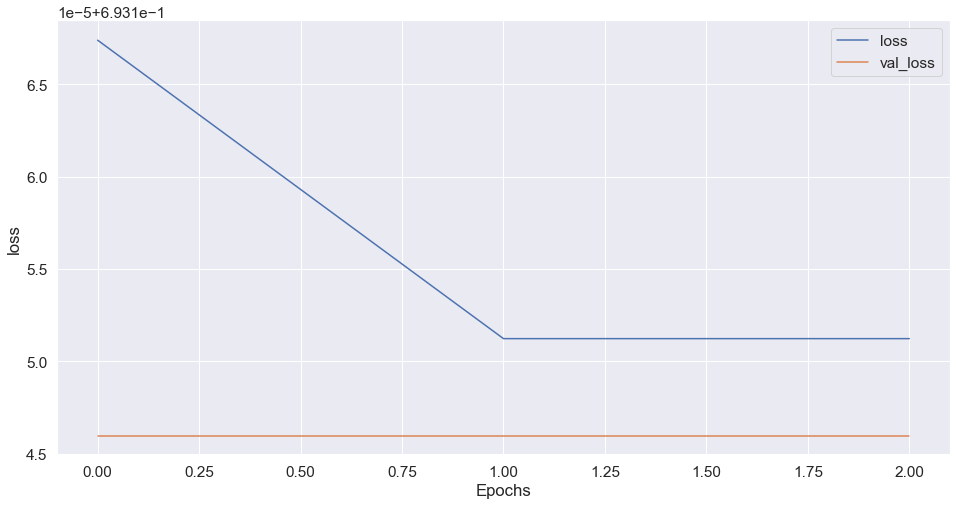

In [54]:
plot_graphs(bilstm, 'loss')

### Criar modelo Random Forest

In [55]:
n_estimators = 100
oobScoresNumber = []
oobScoresScore = []

rf = RandomForestClassifier(warm_start=True, oob_score=True)

for i in range(1, n_estimators + 1):
        rf.set_params(n_estimators=i)
        rf.fit(X_train_rf,y_train)

        oob_error = 1 - rf.oob_score_
        oobScoresNumber.append(i)
        oobScoresScore.append(oob_error)

c:\users\wesllei\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.

c:\users\wesllei\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning:

invalid value encountered in true_divide

c:\users\wesllei\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.

c:\users\wesllei\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning:

invalid value encountered in true_divide

c:\users\wesllei\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning:

Some inputs do not have OOB scores. This probably means too few t

In [81]:
fig = go.Figure(data=[
    go.Scatter(
        x=oobScoresNumber,
        y=oobScoresScore,
        line_shape='linear'
    )
])

fig.update_layout(
    title='OOB Scores',
    xaxis_title='Number of Classifiers',
    yaxis_title='Error',
    width = 900,
    height = 700
)

fig.show()

In [57]:
modelRF = RandomForestClassifier(n_estimators=20)

In [58]:
modelRF.fit(X_train_rf,y_train)

RandomForestClassifier(n_estimators=20)

In [59]:
# Avaliar a importância de cada atributo

featureImp = pd.Series(modelRF.feature_importances_,index=X_train_rf.columns).sort_values(ascending=False)
featureImp

termo_depressao    0.855404
num_palavras       0.095277
link               0.027496
mencao             0.015451
hashtag            0.006372
dtype: float64

In [60]:
fig = go.Figure(data=[
    go.Bar(name='Atributos', x=featureImp, y=featureImp.index,
           text=featureImp, textposition='auto', orientation='h')
])

fig.update_layout(
    title='Importância dos Atributos',
    xaxis_title='Importância',
    yaxis_title='Atributos',
    width = 900,
    height = 700
)

fig.show()

In [85]:
predicted = modelRF.predict(X_test_rf)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2385
           1       1.00      1.00      1.00       693

    accuracy                           1.00      3078
   macro avg       1.00      1.00      1.00      3078
weighted avg       1.00      1.00      1.00      3078



In [86]:
print(confusion_matrix(y_test, predicted))

[[2383    2]
 [   1  692]]


[Text(0, 0.5, 'Não Depressivo'), Text(0, 1.5, 'Depressivo')]

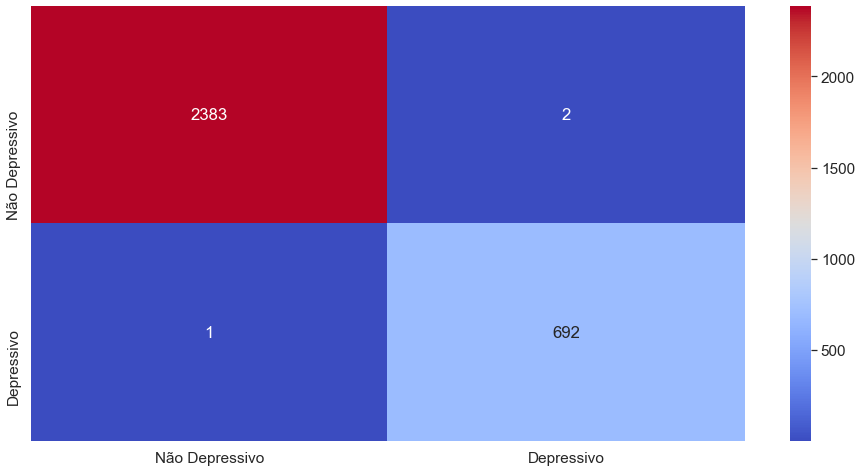

In [88]:
cm = confusion_matrix(y_test, predicted)

sns.set(font_scale=1.4)

fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(cm, cmap='coolwarm', annot=True, fmt='g', ax=ax)
ax.set_xticklabels(['Não Depressivo','Depressivo'])
ax.set_yticklabels(['Não Depressivo','Depressivo'])

### Criar modelo Híbrido
- Modelo 1: Bi-LSTM
- Modelo 2: Random Forest

In [64]:
# Gerar as probabilidades de cada atributo pertencer a cada classe
# Utilizar os dados de treinamento, pois esses valores formarão um novo dataset para o modelo híbrido

predictedScoresBiLSTMTrain = modelBiLSTM.predict_proba(X_train_bilstm)
predictedScoresRFTrain = modelRF.predict_proba(X_train_rf)

predictedScoresBiLSTMTest = modelBiLSTM.predict_proba(X_test_bilstm)
predictedScoresRFTest = modelRF.predict_proba(X_test_rf)

Instructions for updating:
Please use `model.predict()` instead.


In [65]:
predictedScoresBiLSTMTrain = pd.DataFrame(predictedScoresBiLSTMTrain)
predictedScoresRFTrain = pd.DataFrame(predictedScoresRFTrain)

predictedScoresBiLSTMTest = pd.DataFrame(predictedScoresBiLSTMTest)
predictedScoresRFTest = pd.DataFrame(predictedScoresRFTest)

In [66]:
# Criar um novo dataset com as probabilidades e a classe final

dfHibridoTrain = pd.concat([predictedScoresBiLSTMTrain, 
                            predictedScoresRFTrain,
                            y_train.reset_index()['label']], axis=1, sort=False)

dfHibridoTest = pd.concat([predictedScoresBiLSTMTest,
                           predictedScoresRFTest,
                           y_test.reset_index()['label']], axis=1, sort=False)

In [67]:
dfHibridoTrain.columns = ['bilstm_0','bilstm_1','rf_0','rf_1','label']
dfHibridoTest.columns = ['bilstm_0','bilstm_1','rf_0','rf_1','label']

In [68]:
dfHibridoTrain.shape

(7179, 5)

In [69]:
dfHibridoTest.shape

(3078, 5)

In [70]:
dfHibridoTrain.head()

,bilstm_0,bilstm_1,rf_0,rf_1,label
0,0.500003,0.499997,0.0,1.0,1
1,0.500003,0.499997,0.0,1.0,1
2,0.500003,0.499997,1.0,0.0,0
3,0.500003,0.499997,1.0,0.0,0
4,0.500003,0.499997,1.0,0.0,0


In [71]:
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)

In [72]:
X_train = dfHibridoTrain[['bilstm_0','bilstm_1','rf_0','rf_1']]
y_train = dfHibridoTrain['label']

In [73]:
modelABC = abc.fit(X_train, y_train)

In [74]:
X_test = dfHibridoTest[['bilstm_0','bilstm_1','rf_0','rf_1']]
y_test = dfHibridoTest['label']

In [92]:
predicted = modelABC.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2385
           1       1.00      1.00      1.00       693

    accuracy                           1.00      3078
   macro avg       1.00      1.00      1.00      3078
weighted avg       1.00      1.00      1.00      3078



In [93]:
print(confusion_matrix(y_test, predicted))

[[2385    0]
 [   1  692]]


[Text(0, 0.5, 'Não Depressivo'), Text(0, 1.5, 'Depressivo')]

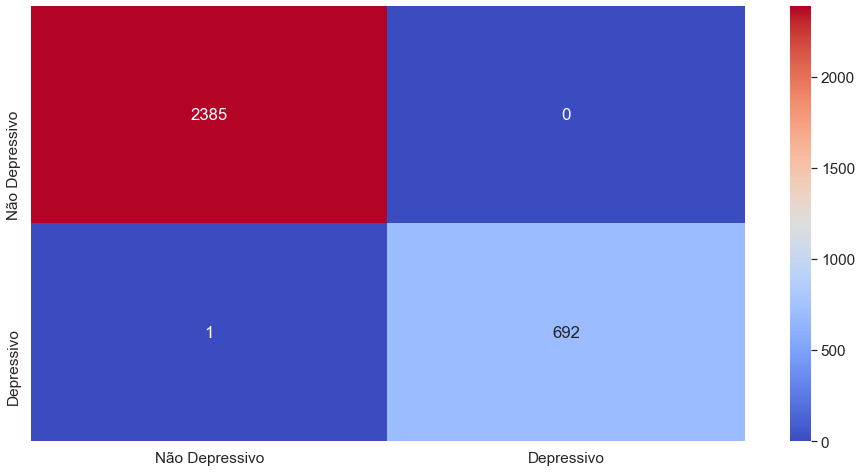

In [95]:
cm = confusion_matrix(y_test, predicted)

sns.set(font_scale=1.4)

fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(cm, cmap='coolwarm', annot=True, fmt='g', ax=ax)
ax.set_xticklabels(['Não Depressivo','Depressivo'])
ax.set_yticklabels(['Não Depressivo','Depressivo'])